In [1]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [2]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoEncoder().to(device)
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [3]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [4]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [5]:
num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')

    log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.244  trn_loss: 0.413  (35.26s - 141.06s remaining)
EPOCH: 2.000  val_loss: 0.092  trn_loss: 0.130  (56.55s - 84.82s remaining)
EPOCH: 3.000  val_loss: 0.074  trn_loss: 0.083  (77.47s - 51.65s remaining)
EPOCH: 4.000  val_loss: 0.066  trn_loss: 0.072  (98.68s - 24.67s remaining)
EPOCH: 5.000  val_loss: 0.061  trn_loss: 0.065  (120.04s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 1865.98it/s]


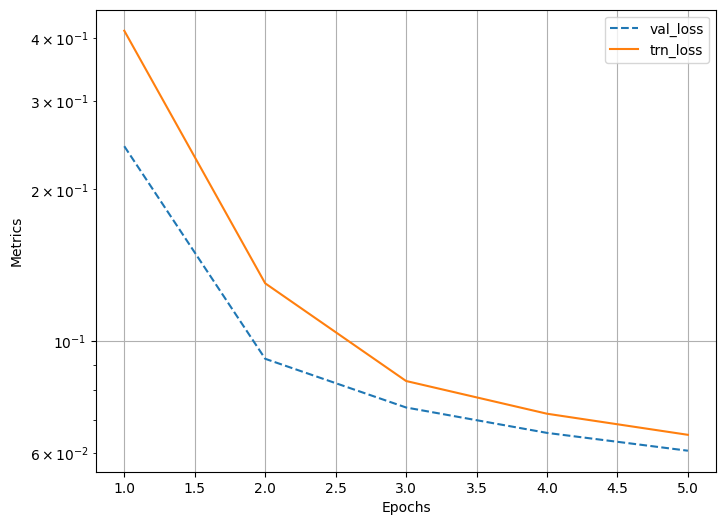

In [6]:
log.plot_epochs(log=True)

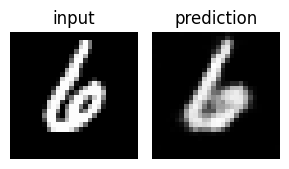

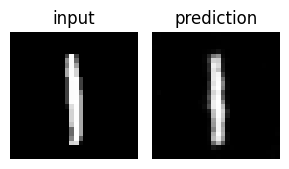

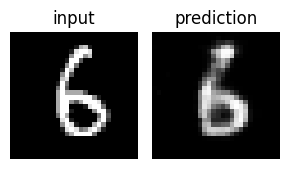

In [7]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

In [8]:
latent_vectors = []
classes = []

for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im), -1))
    classes.extend(clss)

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

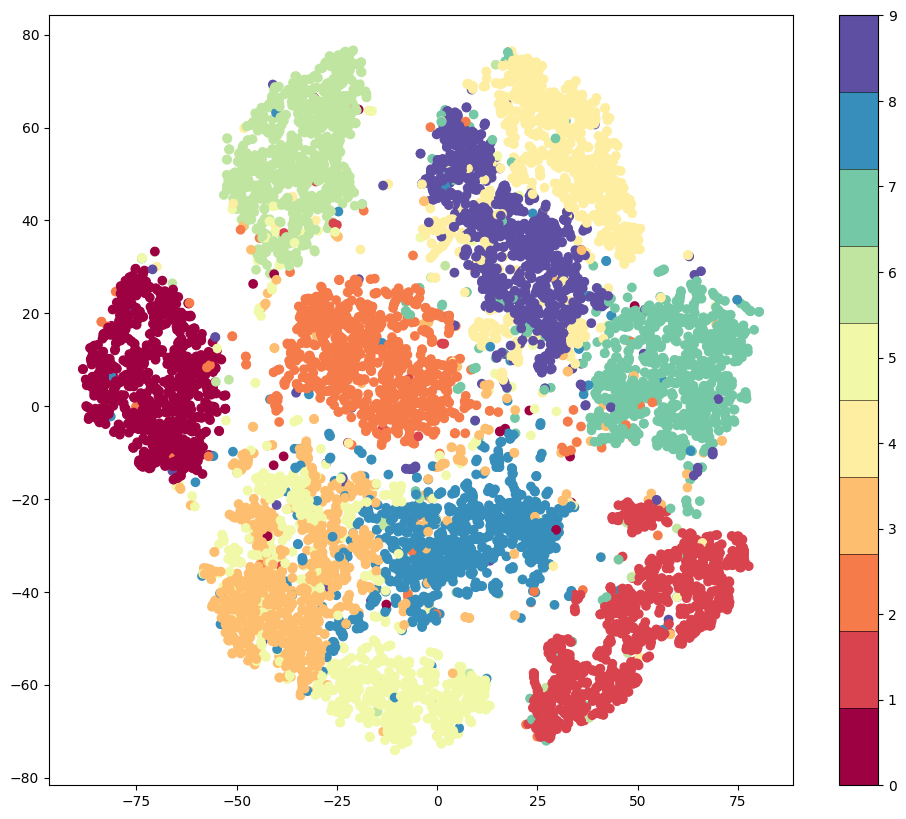

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(2)

clustered = tsne.fit_transform(latent_vectors)

fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

In [10]:
latent_vectors = []
classes = []
for im, clss in val_dl:
    latent_vectors.append(model.encoder(im))
    classes.extend(clss)
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(10000, -1)

In [11]:
rand_vectors = []
for col in latent_vectors.transpose(1,0):
    mu, sigma = col.mean(), col.std()
    rand_vectors.append(sigma*torch.randn(1,100) + mu)

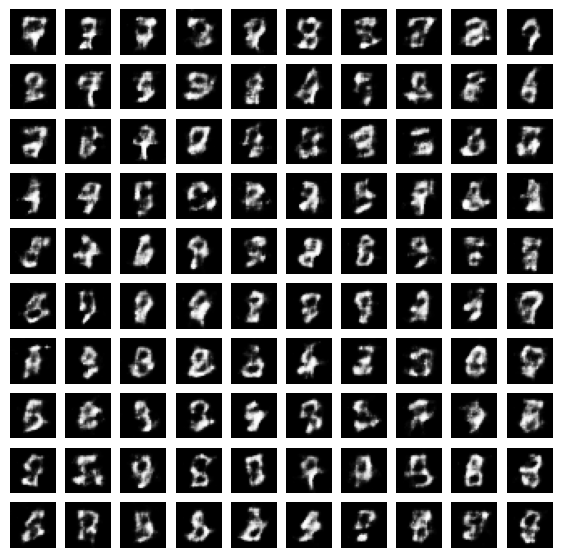

In [12]:
rand_vectors = torch.cat(rand_vectors).transpose(1,0).to(device)
fig, ax = plt.subplots(10,10,figsize=(7,7)); ax = iter(ax.flat)
for p in rand_vectors:
    img = model.decoder(p.reshape(1,64,2,2)).view(28,28)
    show(img, ax=next(ax))

---